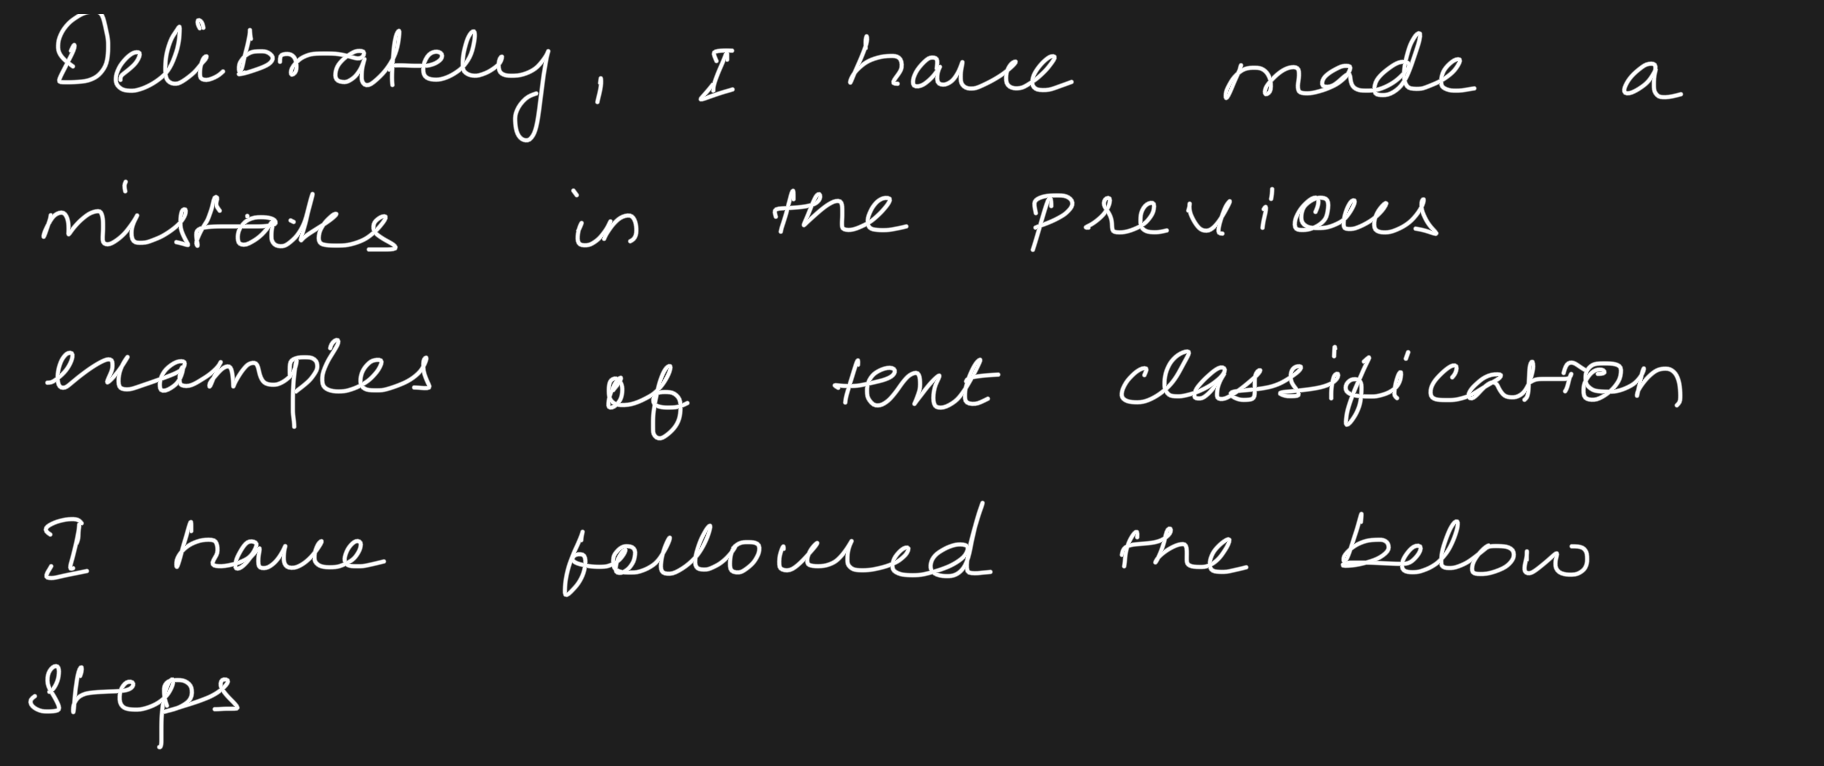
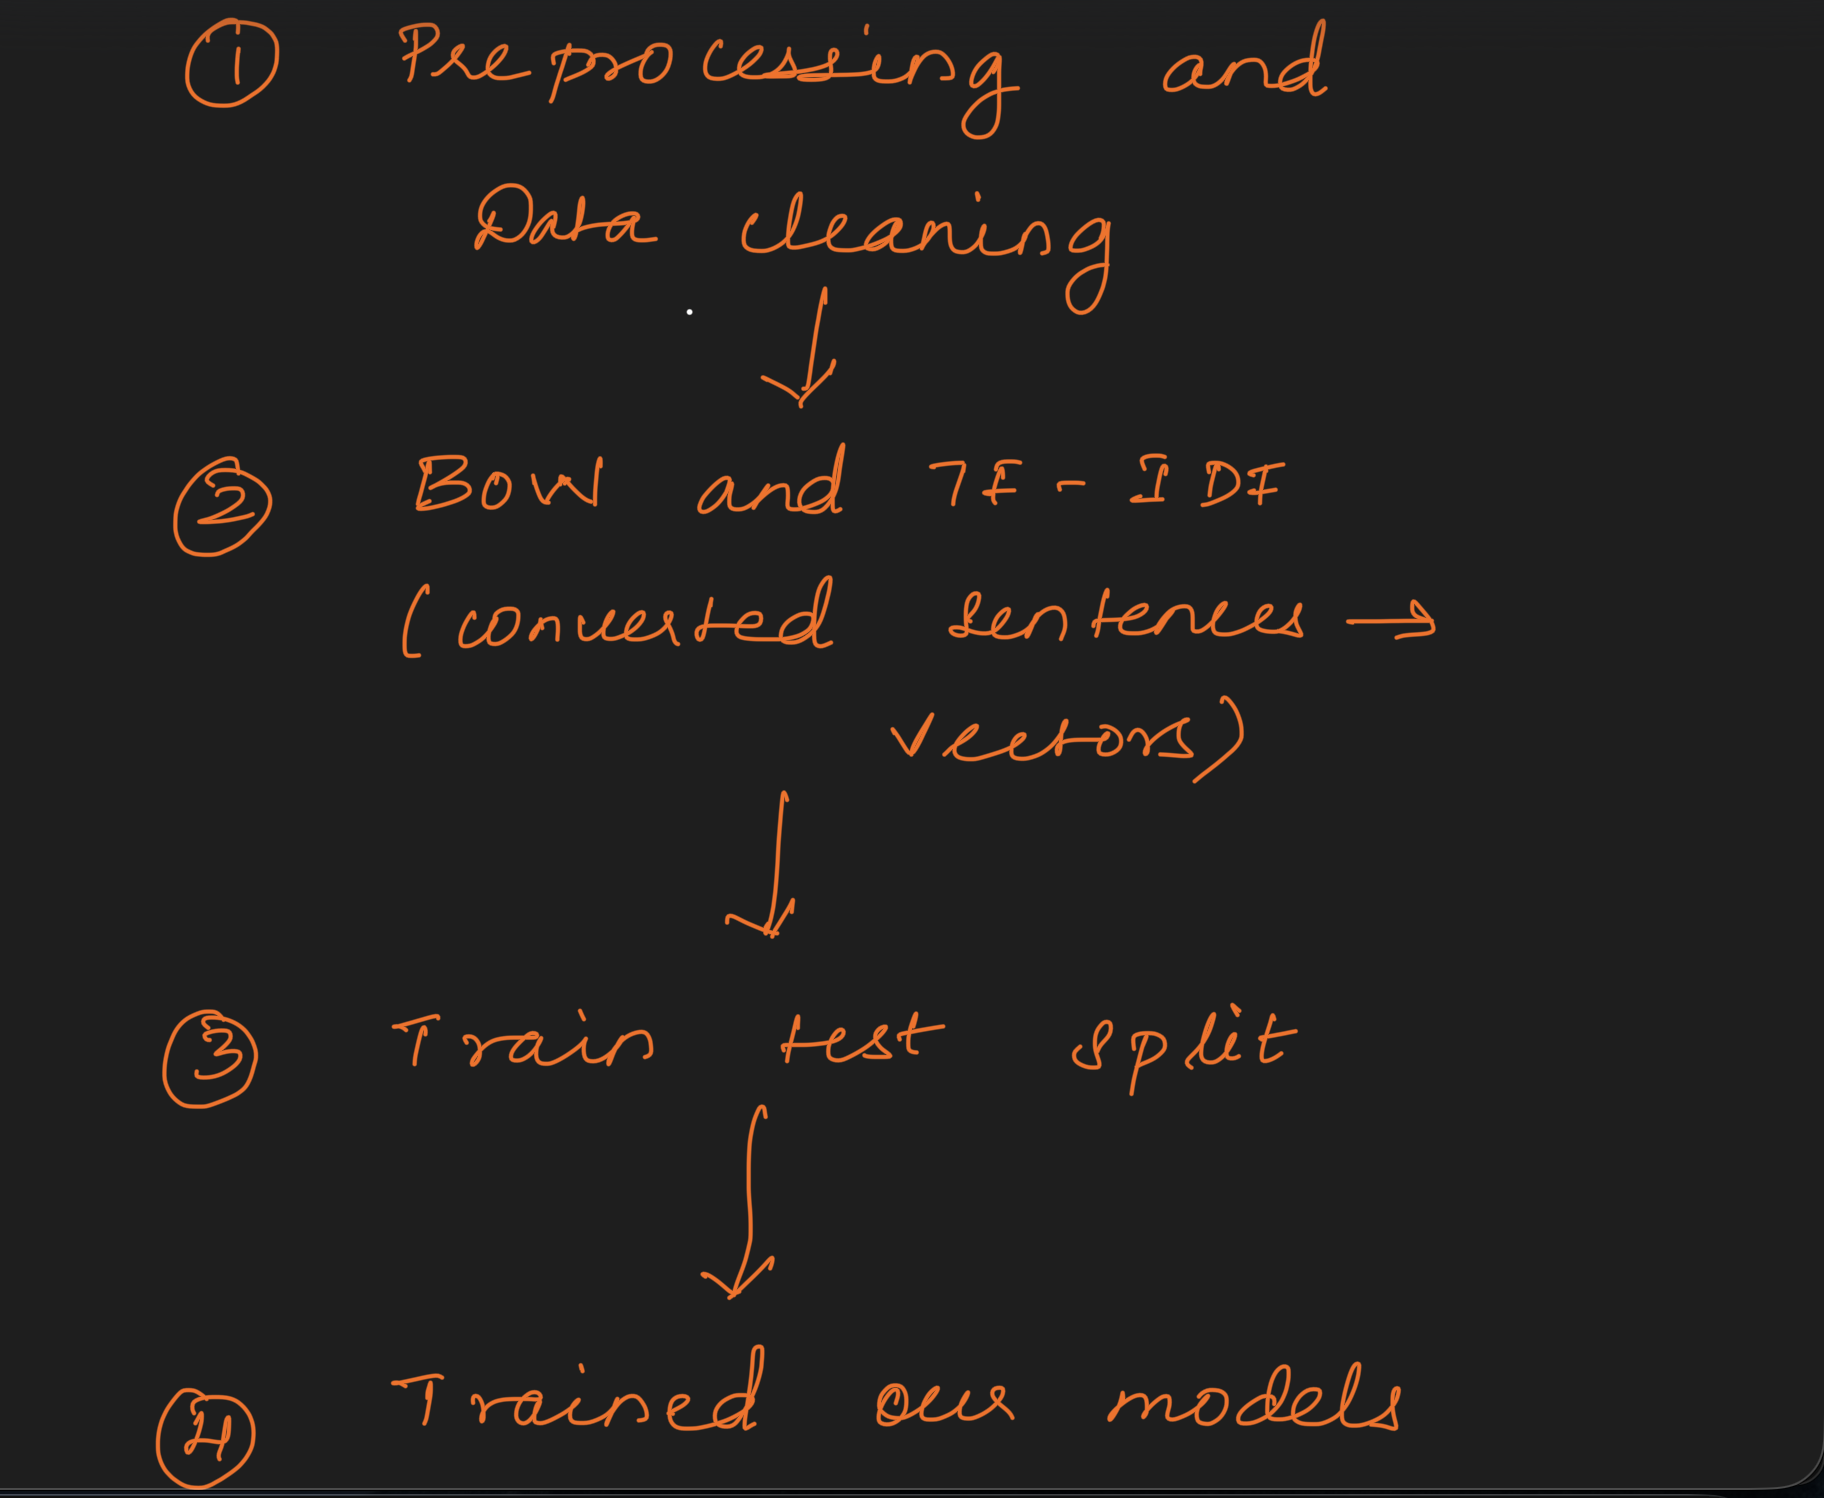
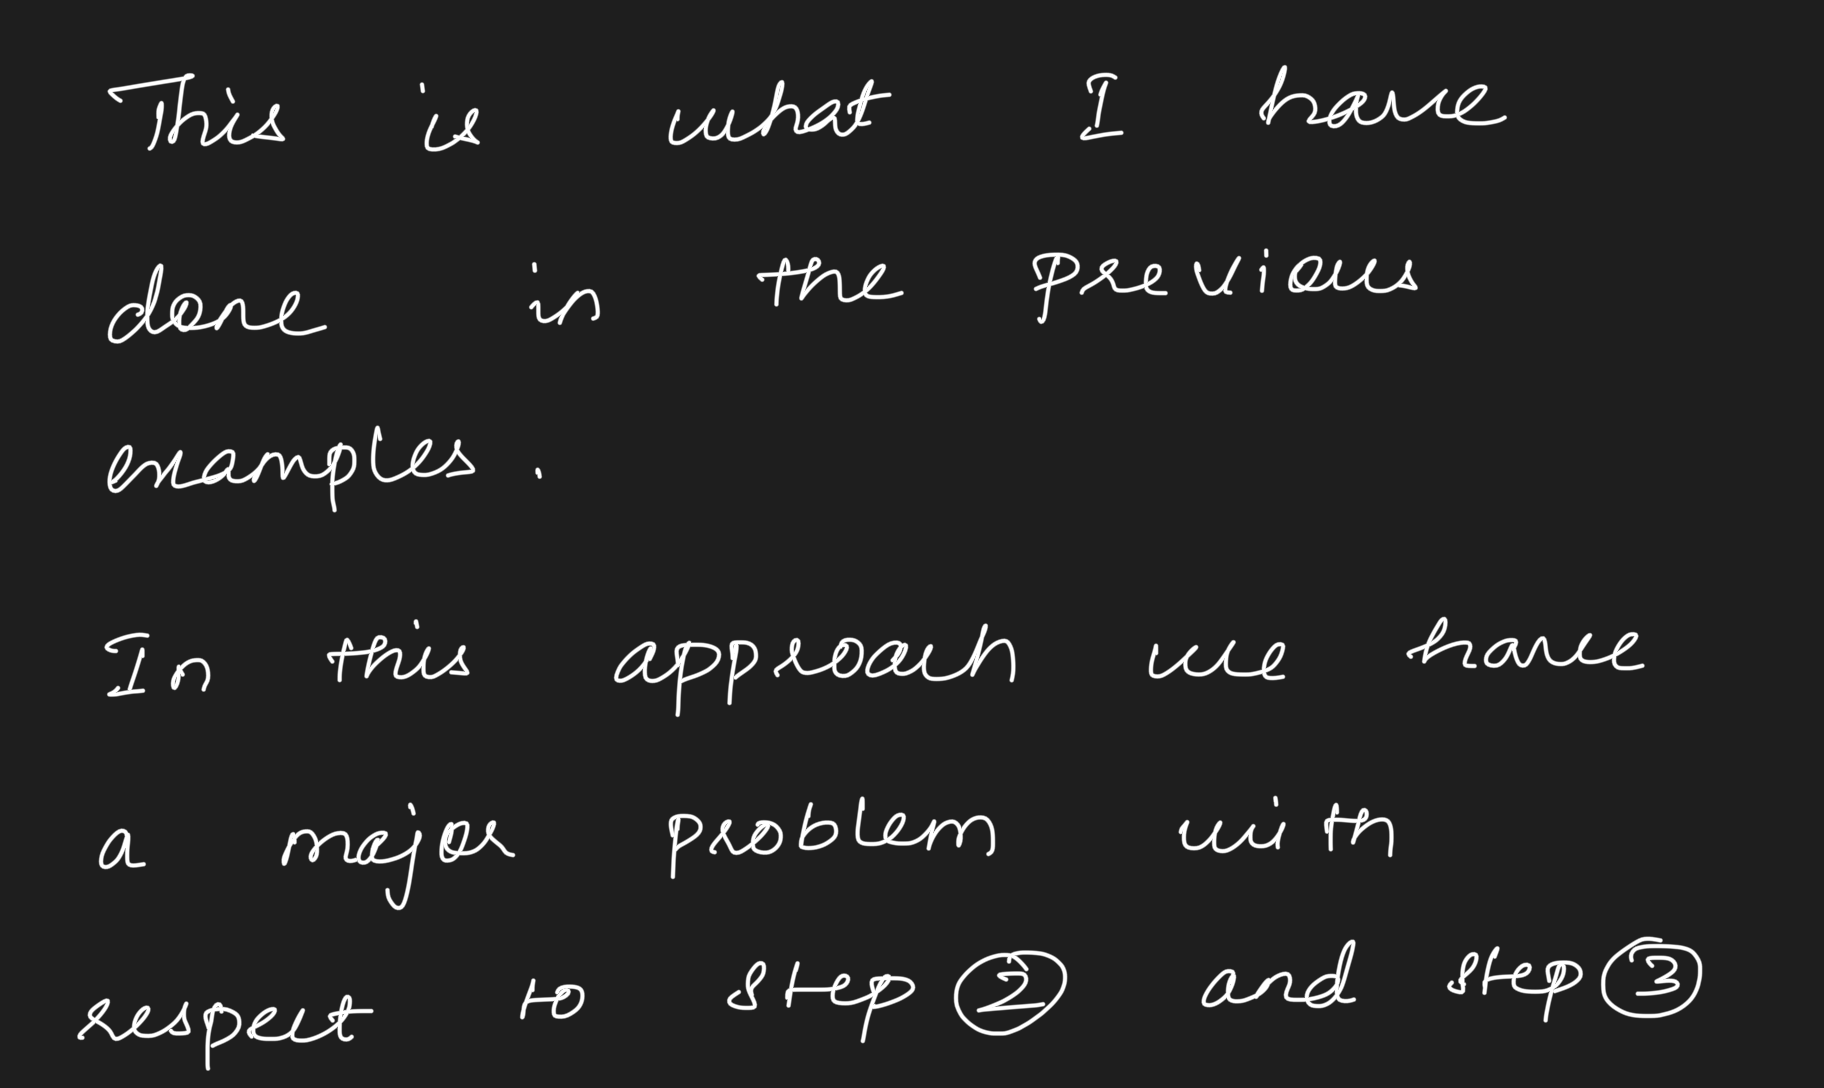
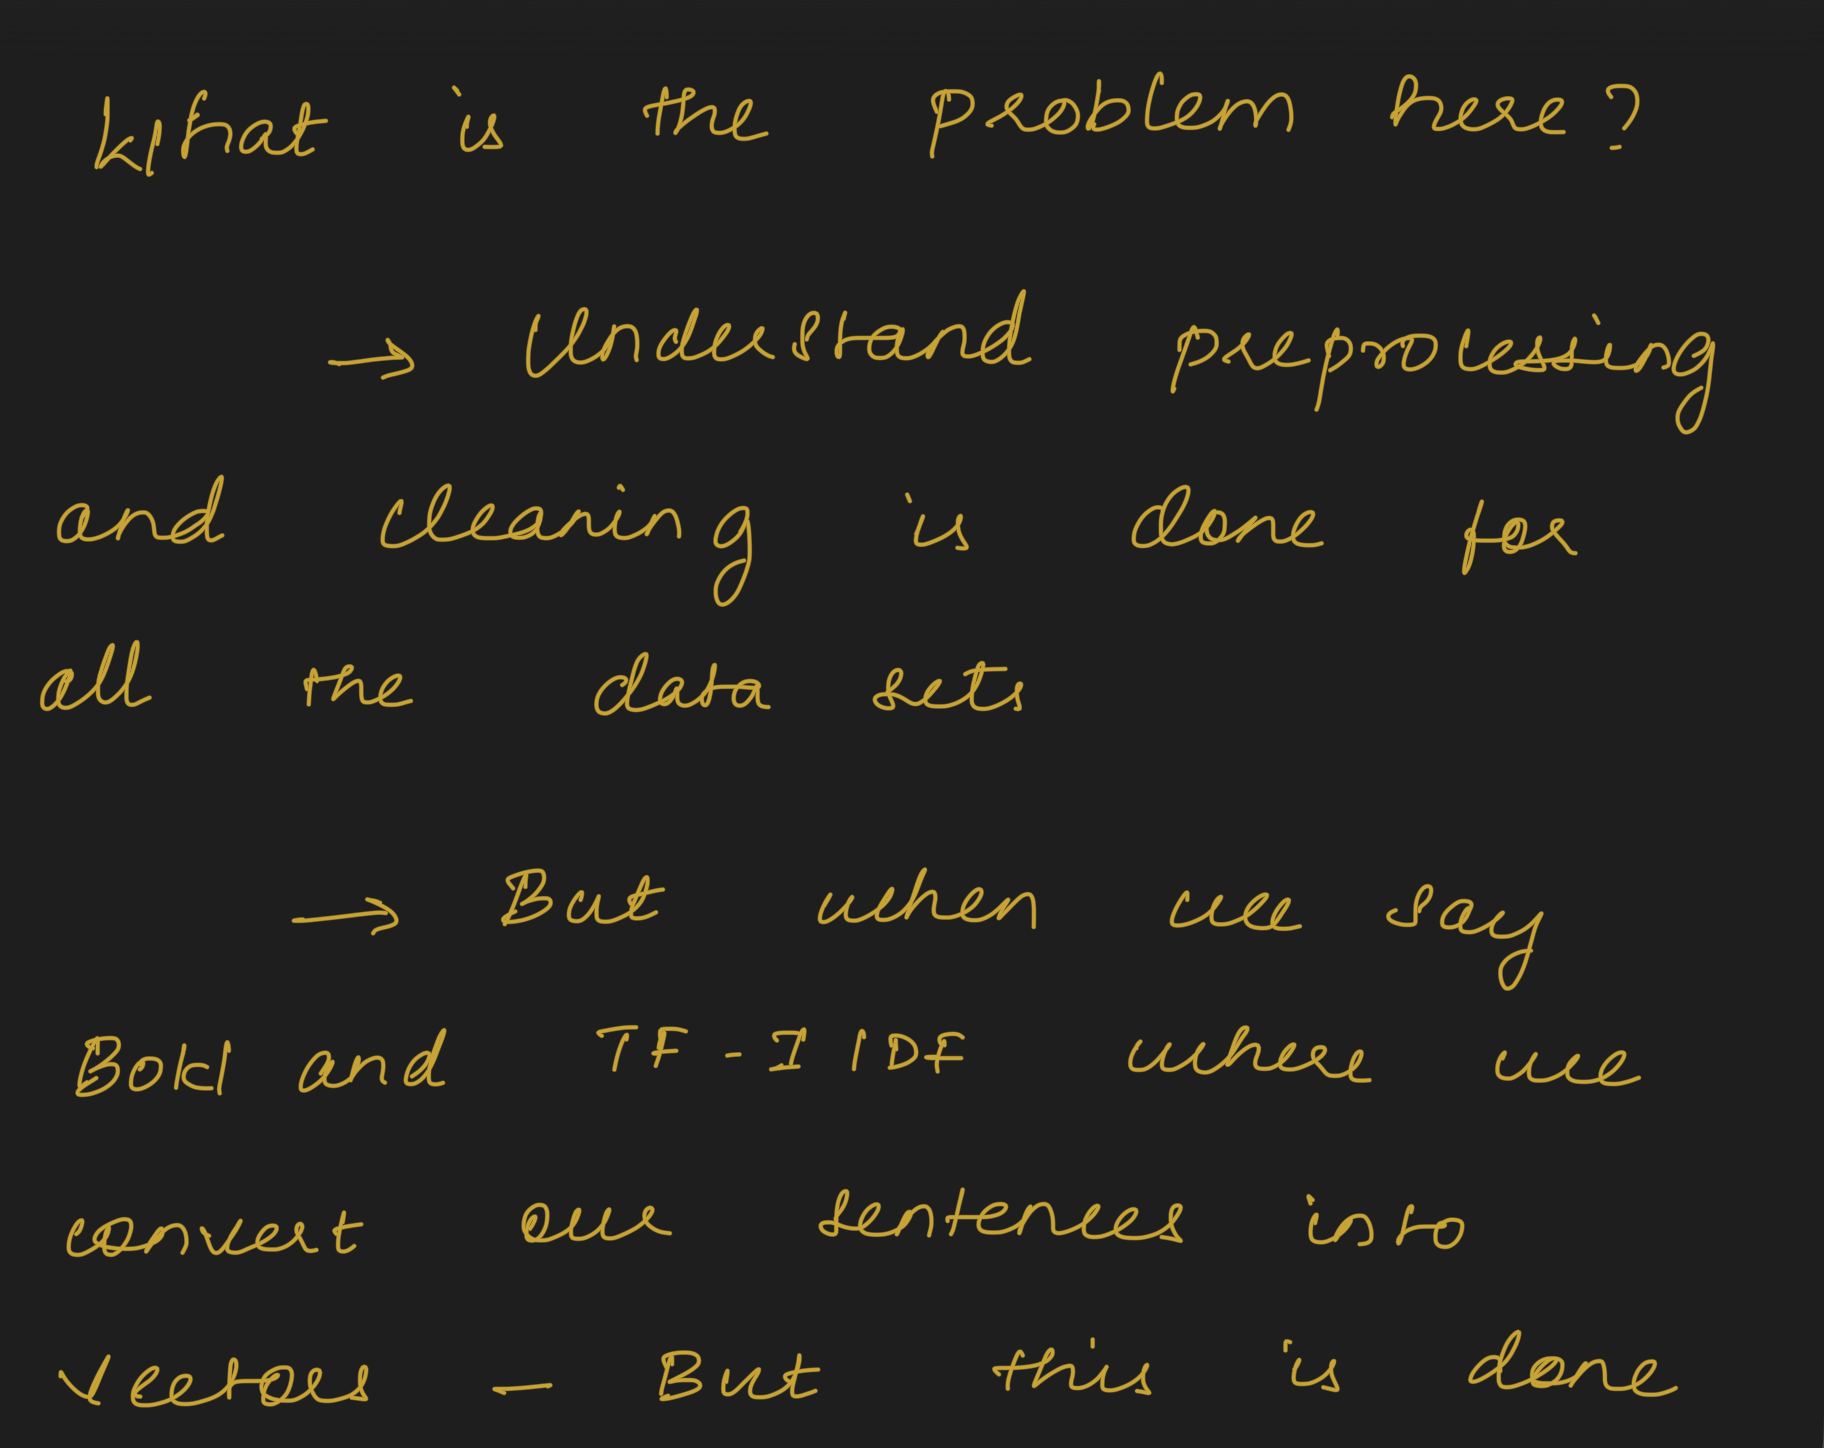
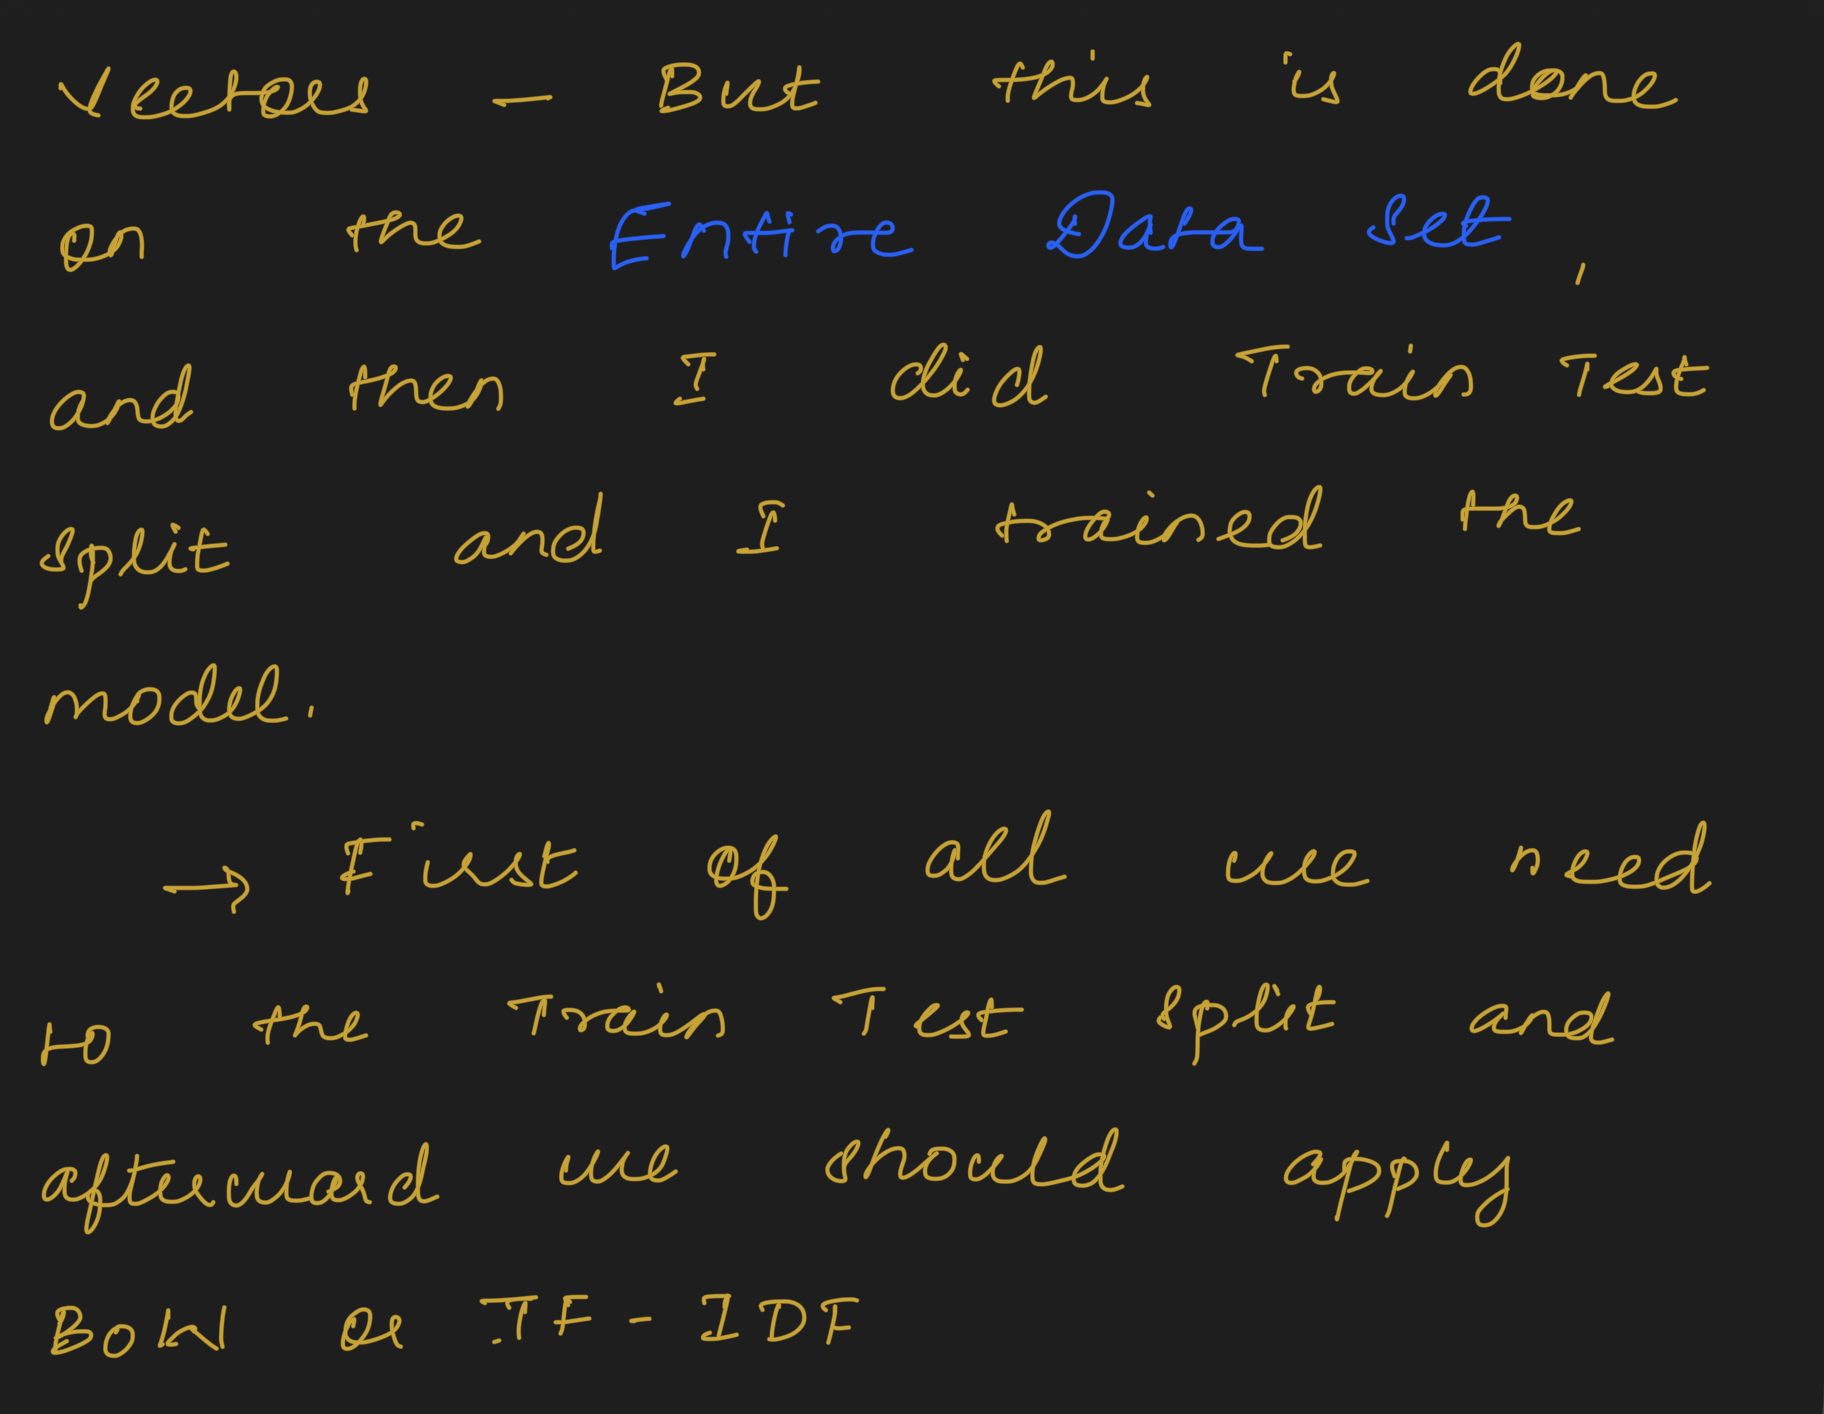
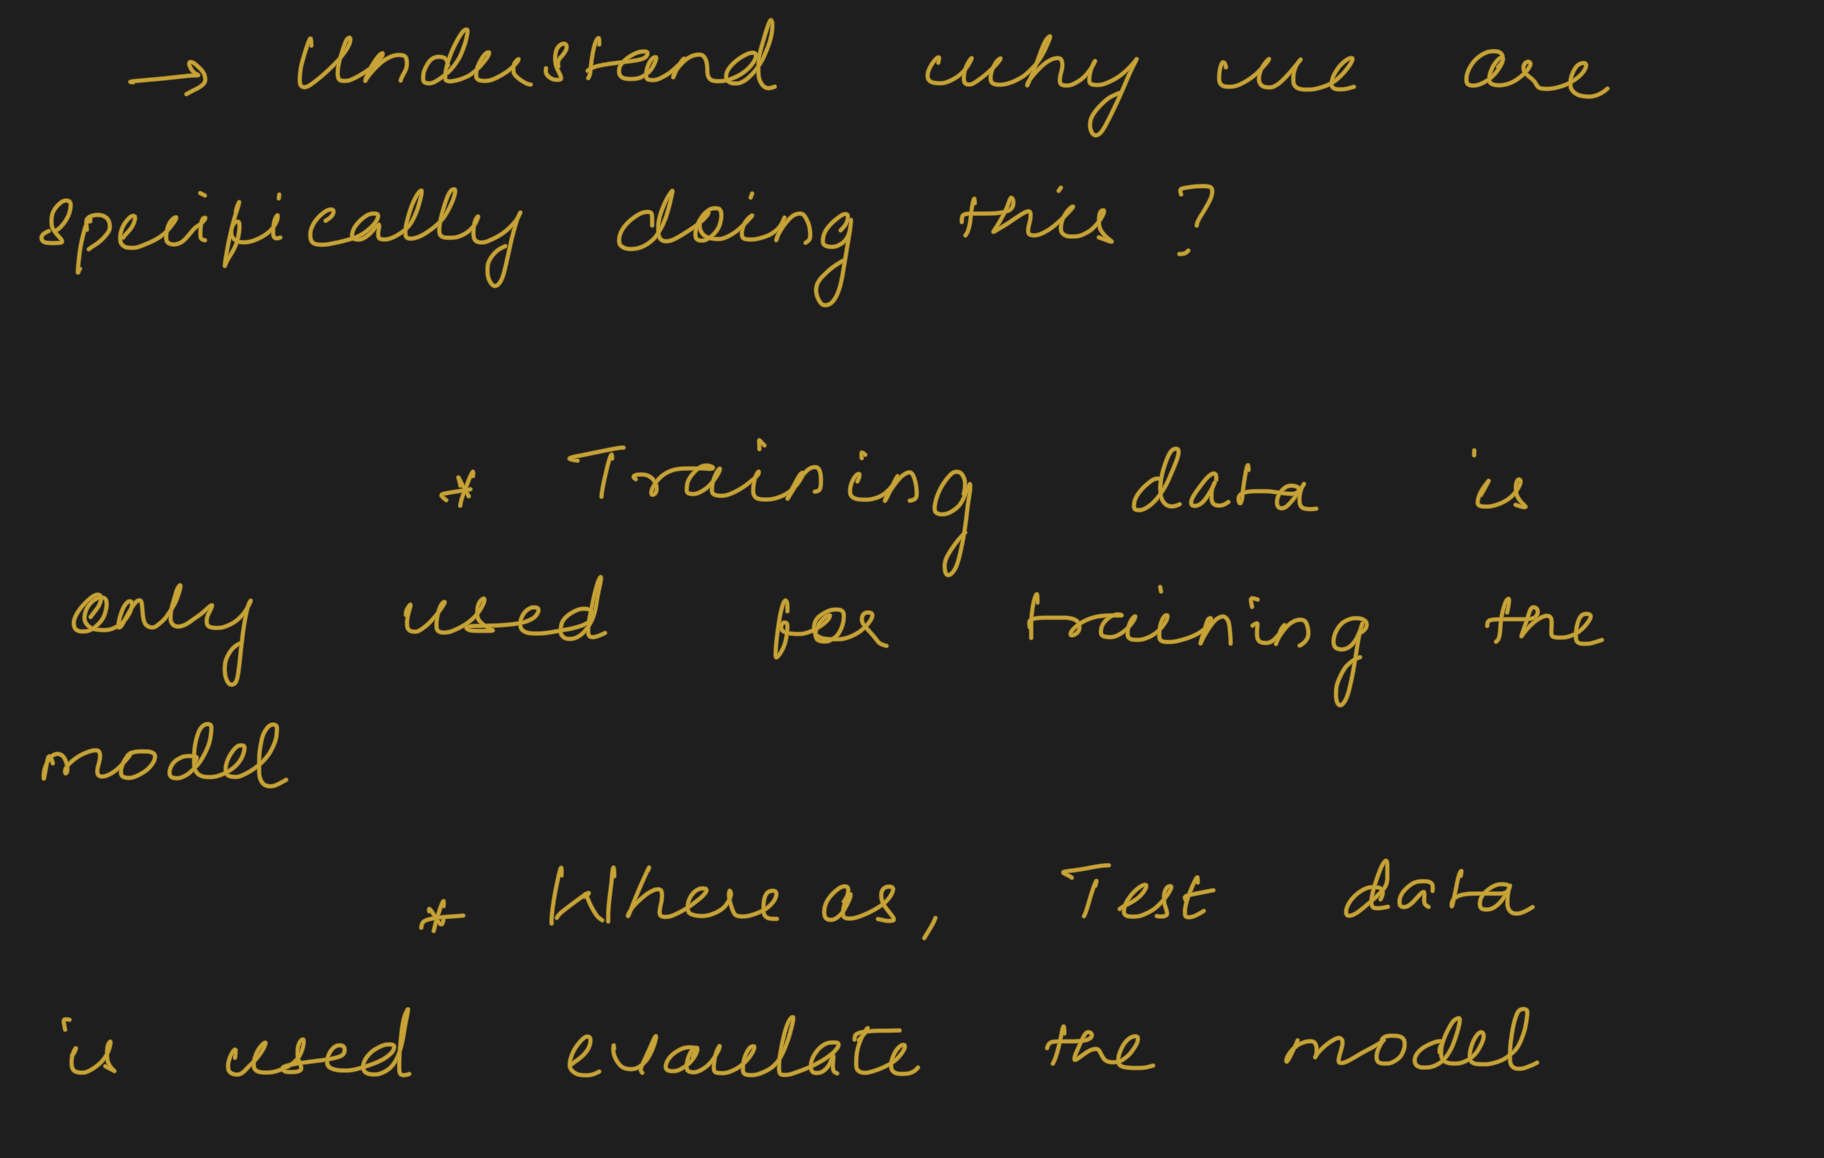
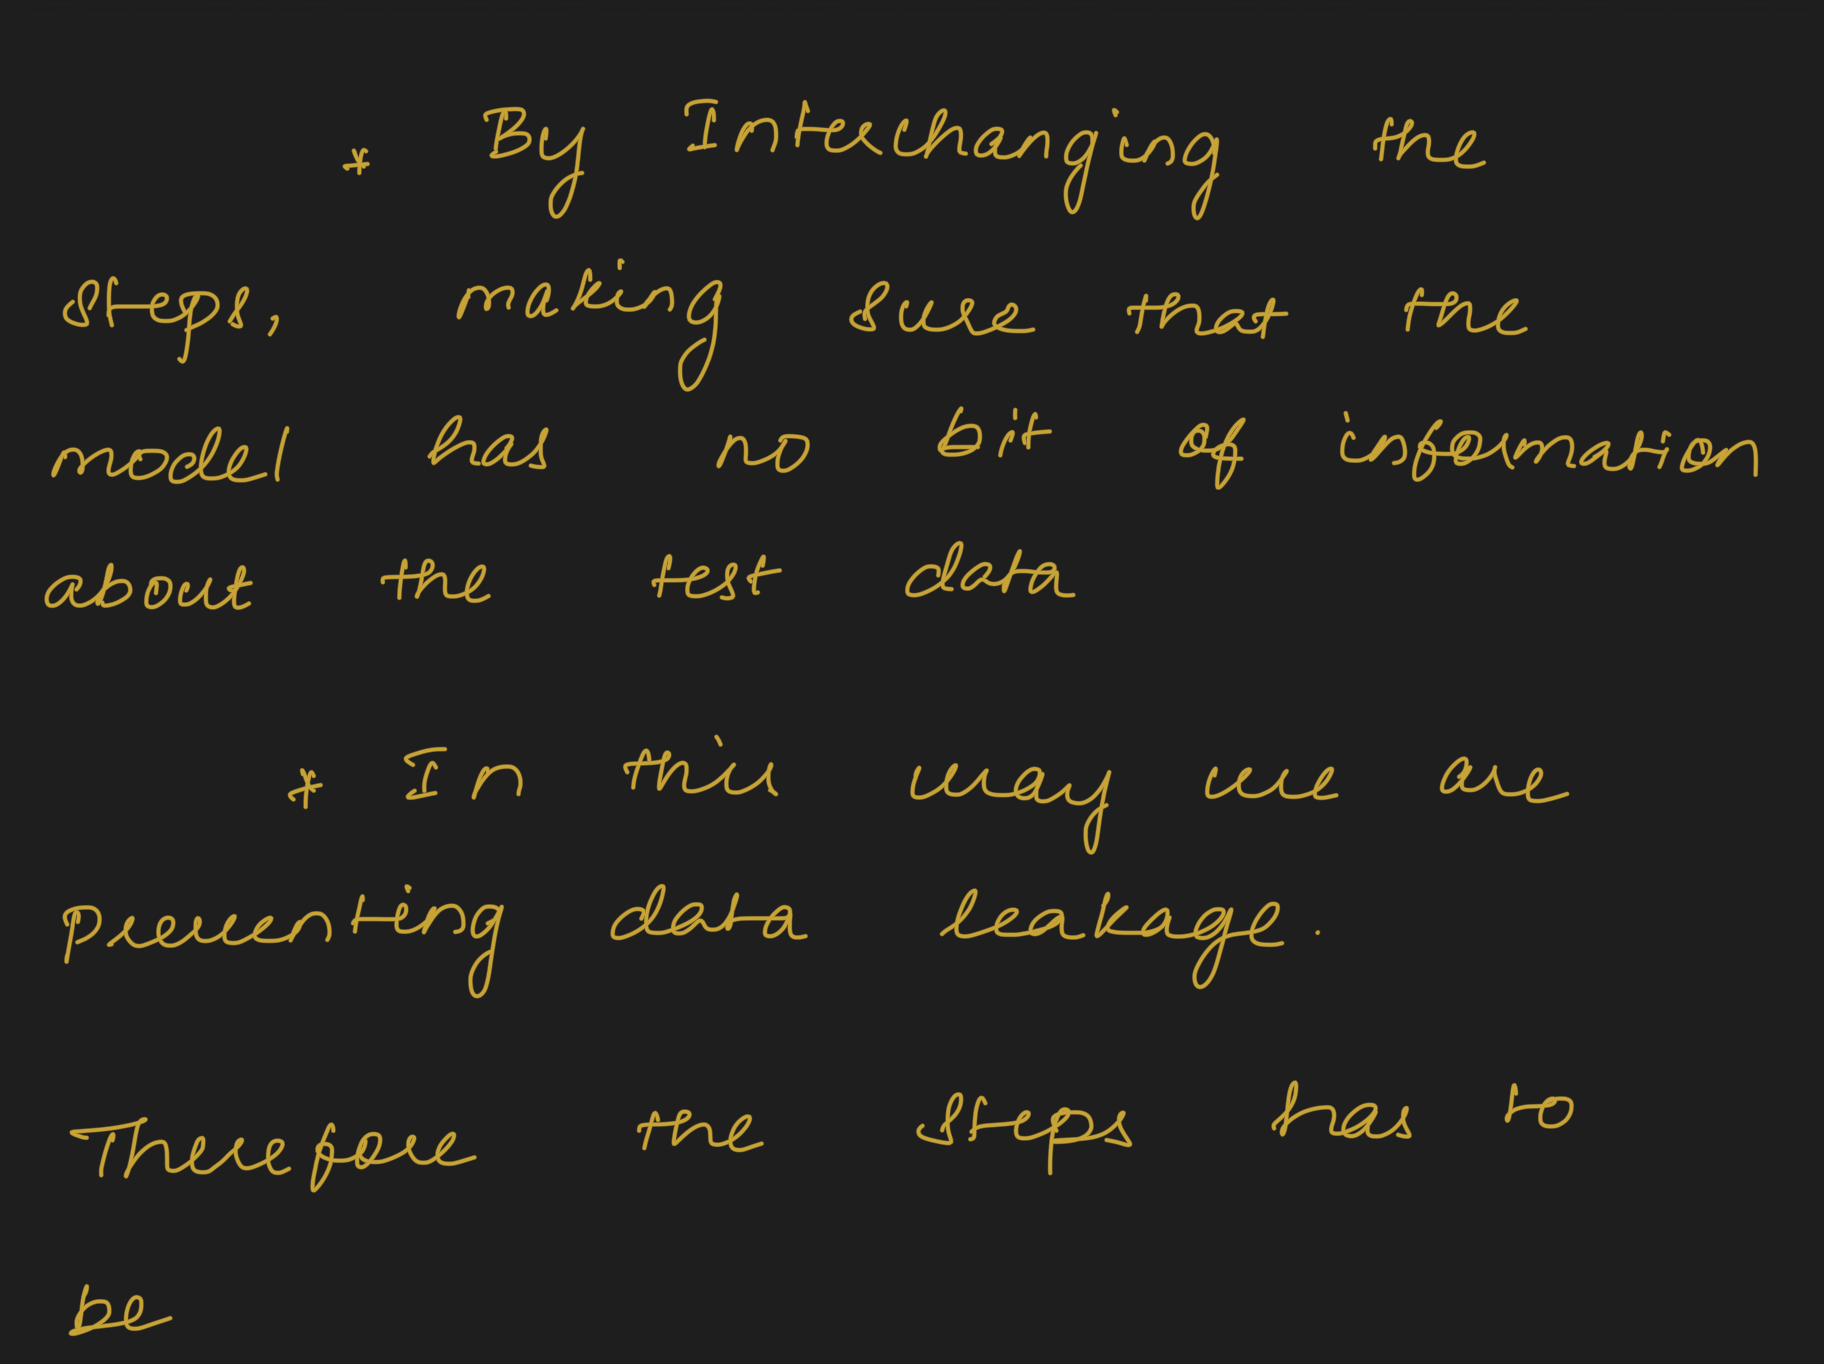
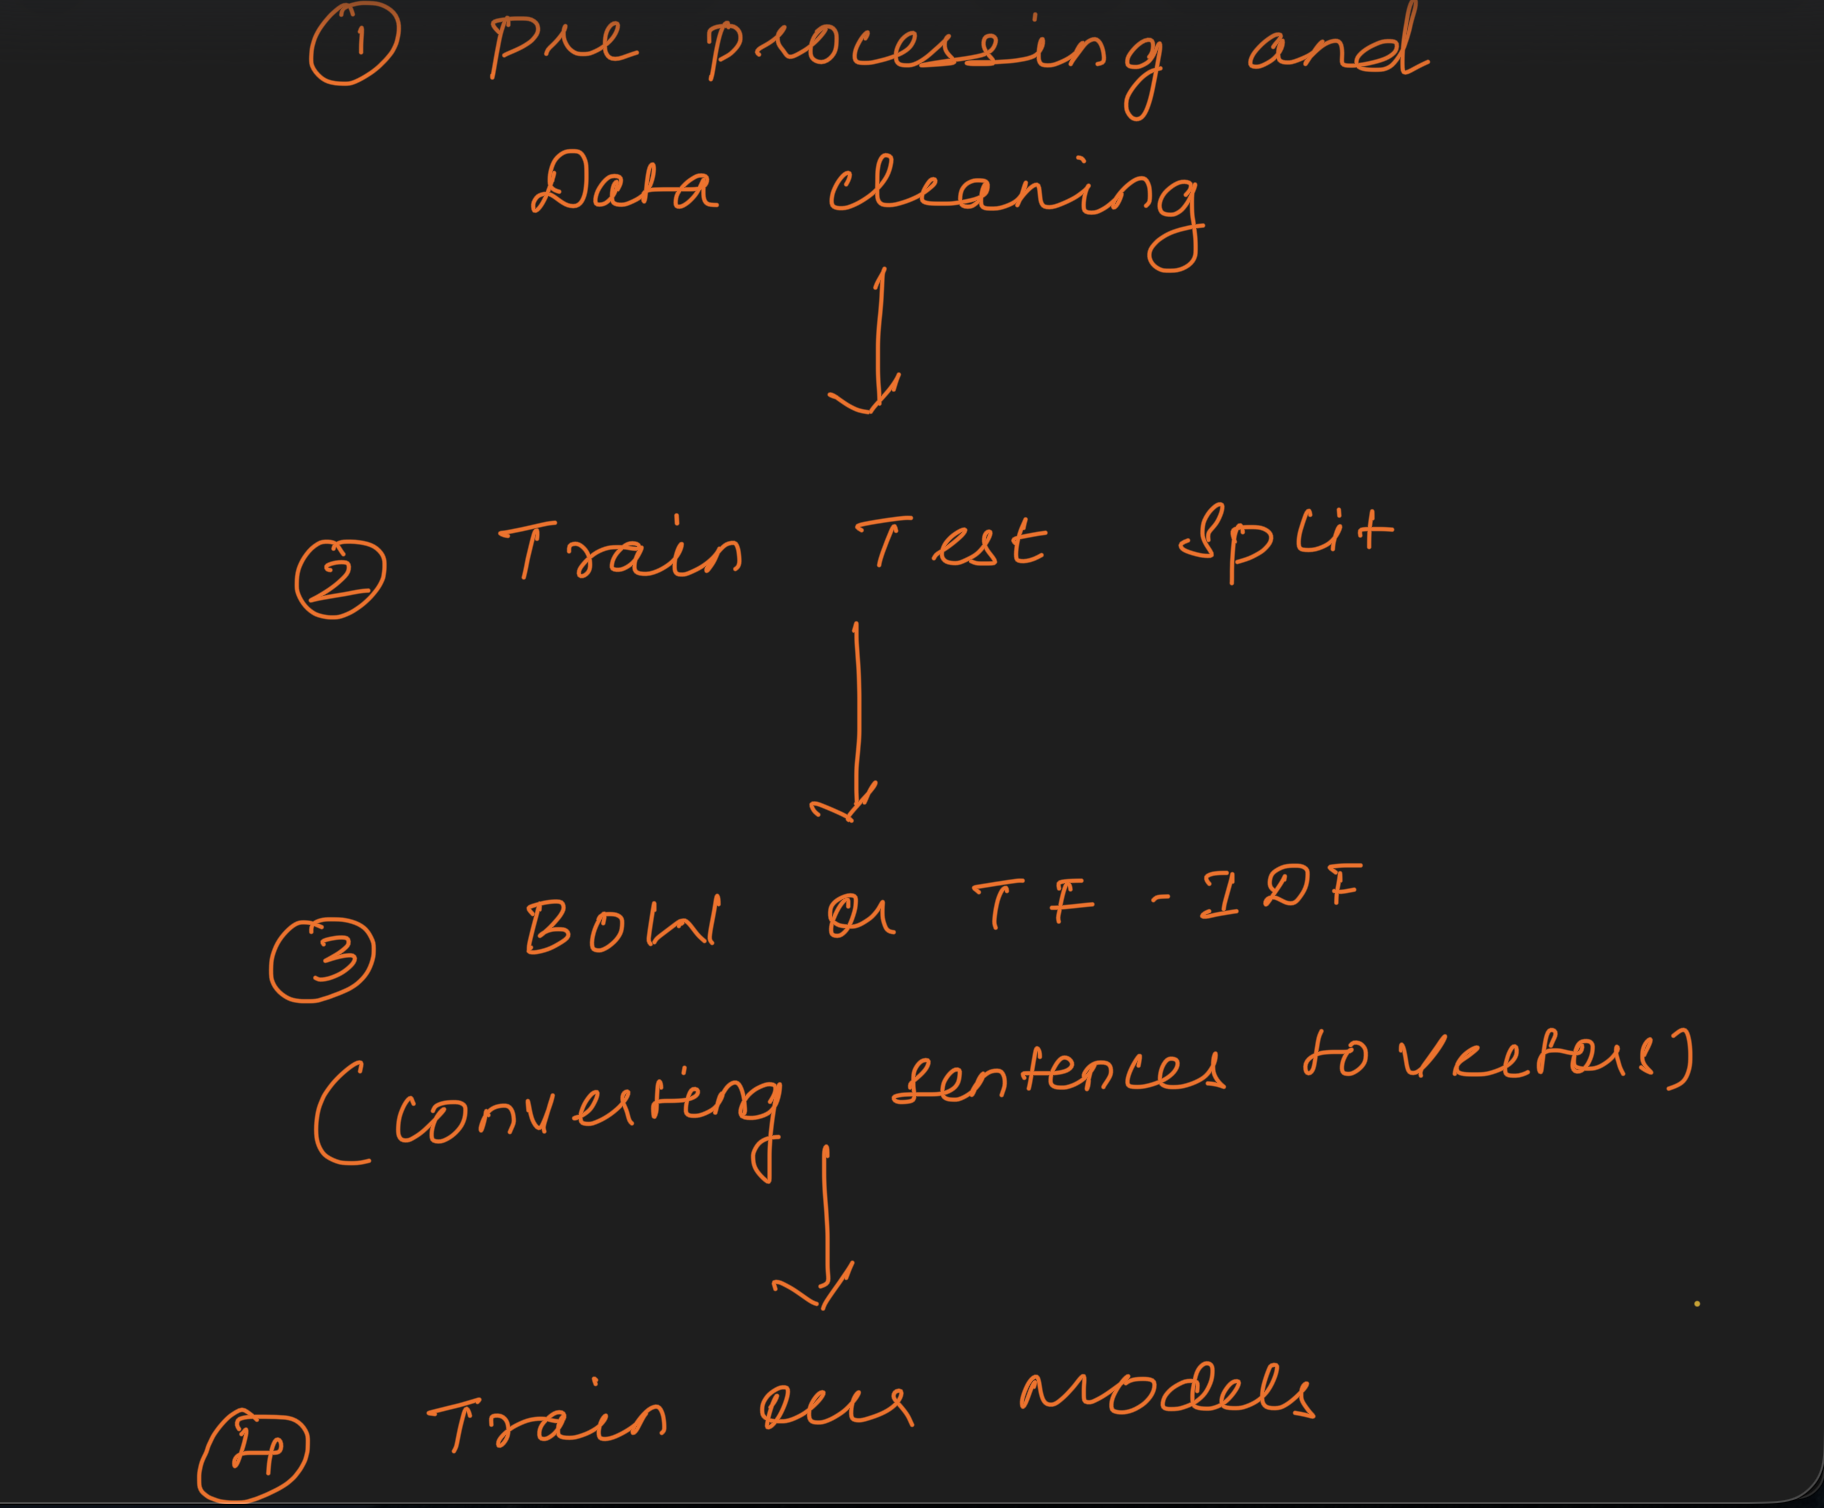

In [1]:
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize  # sent_tokenize not needed here

# If needed (run once in environment):
# import nltk
# nltk.download('punkt')
# nltk.download('stopwords')

# Read the SMS Spam Collection file into a DataFrame.
# File expected to be tab-separated with two columns: label and message.
messages = pd.read_csv('SMSSpamCollection.txt', sep='\t', names=['label', 'message'])

# ---- Build stopwords ONCE ----
# Get the set of English stopwords from NLTK. Converting to a set
# gives O(1) lookups during token filtering and avoids rebuilding it
# inside the loop for every message.
stop_words = set(stopwords.words('english'))

# Corpus will hold cleaned text strings (one per message).
corpus = []
for i in range(len(messages)):
    # 1) Remove all non-letter characters and lowercase the text.
    #    This removes numbers, punctuation, URLs, etc., leaving only letters and spaces.
    review = re.sub('[^a-zA-Z]', ' ', messages['message'][i]).lower()

    # 2) Tokenize the cleaned text into word tokens.
    #    word_tokenize splits on whitespace and punctuation (we already removed most punctuation).
    tokens = word_tokenize(review)

    # 3) Filter tokens:
    #    - keep alphabetic tokens only (filter out residual tokens like empty strings),
    #    - remove stopwords to reduce noise (common words that don't help classification).
    #    This is done once per message; using the prebuilt stop_words set is efficient.
    filtered_words = [w for w in tokens if w.isalpha() and w not in stop_words]

    # 4) Join the filtered tokens back into a single cleaned string and append to corpus.
    #    The vectorizer later expects raw strings (one per sample).
    corpus.append(' '.join(filtered_words))

# ---- Label encoding ----
# Convert textual labels ('ham'/'spam') into numeric labels (0/1) using LabelEncoder.
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
y = labelencoder.fit_transform(messages['label'])  # y is a 1D numpy array of ints

# ---- Train-test split (keep RAW TEXTS) ----
# We split the cleaned text corpus into train and test while preserving the raw cleaned
# strings (not yet vectorized). Use stratify=y to maintain class balance in splits.
from sklearn.model_selection import train_test_split
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    corpus, y, test_size=0.2, random_state=42, stratify=y
)

# Print sizes to verify split
print(f"# raw train size: {len(X_train_raw)}")
print(f"# raw test  size: {len(X_test_raw)}")

# ---- TF-IDF Vectorization ----
# Convert raw cleaned strings to TF-IDF feature vectors.
# - max_features limits dimensionality (keeps top 2500 features by term frequency).
# - lowercase=True ensures consistent casing (we already lowercased, but safe to keep).
# - ngram_range=(1,2) includes unigrams and bigrams which can capture spammy phrases.
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(
    max_features=2500,
    lowercase=True,
    ngram_range=(1, 2)  # unigrams + bigrams (helps capture short phrase cues)
)

# Fit the vectorizer on the training raw texts and transform both train and test sets.
# The result is a sparse CSR matrix of shape (n_samples, n_features).
X_train_vec = tfidf_vectorizer.fit_transform(X_train_raw)  # (n_train, 2500), csr
X_test_vec  = tfidf_vectorizer.transform(X_test_raw)       # (n_test,  2500), csr

# Print resulting matrix shapes (sparse matrices)
print("Independent Features")
print("---------------------")
print(f"X_train_vec: {X_train_vec.shape}")
print(f"X_test_vec : {X_test_vec.shape}")

# ---- Train a Multinomial Naive Bayes classifier ----
# MultinomialNB is appropriate for count/TF-IDF style features and performs well on text.
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

nb_clf = MultinomialNB()
nb_clf.fit(X_train_vec, y_train)  # Train classifier on TF-IDF features

# Predict on the test set and evaluate performance
y_pred = nb_clf.predict(X_test_vec)

acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
print(f"# Test Accuracy: {acc:.4f}")
print("# Confusion Matrix (rows=true, cols=pred):\n", cm)

print("# Classification Report (named classes):")
# target_names are the original string class labels recovered from the label encoder
print(classification_report(y_test, y_pred, target_names=labelencoder.classes_, zero_division=0))

# ---- Show some TEST samples with predictions ----
# Print a few test samples alongside predicted and true labels for qualitative inspection.
print("\n# Sample Test Predictions")
print("------------------------")
N = min(20, len(X_test_raw))  # limit output to at most 20 samples
for i in range(N):
    # Use the raw cleaned string for display
    text = X_test_raw[i]

    # Extract the corresponding 2D row from the sparse test matrix so it can be fed to predict().
    # Keep shape (1, n_features) with slicing [i:i+1].
    vec  = X_test_vec[i:i+1]

    # Predict single sample and map numeric class to a human-friendly label.
    pred = nb_clf.predict(vec)[0]
    pred_label = 'SPAM 🚨' if pred == 1 else 'HAM ✅'
    true_label = 'SPAM' if y_test[i] == 1 else 'HAM'

    # Print a truncated text for readability, and the prediction vs actual
    print(f"Text: {text[:80]}...")
    print(f"Pred : {pred_label} | Actual: {true_label}")
    print("-" * 80)


# raw train size: 4457
# raw test  size: 1115
Independent Features
---------------------
X_train_vec: (4457, 2500)
X_test_vec : (1115, 2500)
# Test Accuracy: 0.9776
# Confusion Matrix (rows=true, cols=pred):
 [[965   1]
 [ 24 125]]
# Classification Report (named classes):
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       966
        spam       0.99      0.84      0.91       149

    accuracy                           0.98      1115
   macro avg       0.98      0.92      0.95      1115
weighted avg       0.98      0.98      0.98      1115


# Sample Test Predictions
------------------------
Text: need buy lunch eat maggi mee...
Pred : HAM ✅ | Actual: HAM
--------------------------------------------------------------------------------
Text: ok im sure time finish tomorrow wan na spend evening cos would vewy vewy lubly l...
Pred : HAM ✅ | Actual: HAM
--------------------------------------------------------------------------------
Text

In [2]:
new_text = "WIN a FREE prize! Click here now."
new_vec  = tfidf_vectorizer.transform([new_text])  # shape (1, 2500)
pred     = nb_clf.predict(new_vec)[0]
print("Prediction:", "SPAM 🚨" if pred == 1 else "HAM ✅")


Prediction: SPAM 🚨


In [3]:
new_text = "Hey! PS a call for you"
new_vec  = tfidf_vectorizer.transform([new_text])  # shape (1, 2500)
pred     = nb_clf.predict(new_vec)[0]
print("Prediction:", "SPAM 🚨" if pred == 1 else "HAM ✅")


Prediction: HAM ✅
